The following code was designed to explore accelerometer data extracted from 50 subjects' phones, while executing various activities. 

complementary to Roni Agmon's project, three objectives were set: 

1. standardizing times across subjects and activities.

2. cleaning of gravity vector from all activities.

3. extracting velocity based on acceleration\time data.

In [ ]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
#import sensormotion as sm
import seaborn as sns
%matplotlib inline

First thing is to form up the initial dataframe:

In [ ]:
# NOTE: use files_all for all files in the directory
# files = ['data_1600_accel_phone.txt', 'data_1601_accel_phone.txt'
#          'data_1602_accel_phone.txt', 'data_1603_accel_phone.txt'
#          'data_1604_accel_phone.txt', 'data_1605_accel_phone.txt'
#          'data_1606_accel_phone.txt', 'data_1607_accel_phone.txt'
#          'data_1608_accel_phone.txt', 'data_1609_accel_phone.txt'
#          'data_1610_accel_phone.txt', 'data_1611_accel_phone.txt'
#          'data_1612_accel_phone.txt', 'data_1613_accel_phone.txt'
#          'data_1614_accel_phone.txt', 'data_1615_accel_phone.txt'
#          'data_1616_accel_phone.txt', 'data_1617_accel_phone.txt'
#          'data_1618_accel_phone.txt', 'data_1619_accel_phone.txt'
#          'data_1620_accel_phone.txt', 'data_1621_accel_phone.txt'
#          'data_1622_accel_phone.txt', 'data_1623_accel_phone.txt'
#          'data_1624_accel_phone.txt', 'data_1625_accel_phone.txt'
#          'data_1626_accel_phone.txt', 'data_1627_accel_phone.txt'
#          'data_1628_accel_phone.txt', 'data_1629_accel_phone.txt'
#          'data_1630_accel_phone.txt', 'data_1631_accel_phone.txt'
#          'data_1632_accel_phone.txt', 'data_1633_accel_phone.txt'
#          'data_1634_accel_phone.txt', 'data_1635_accel_phone.txt'
#          'data_1636_accel_phone.txt', 'data_1637_accel_phone.txt'
#          'data_1638_accel_phone.txt', 'data_1639_accel_phone.txt'
#          'data_1640_accel_phone.txt', 'data_1641_accel_phone.txt'
#          'data_1642_accel_phone.txt', 'data_1643_accel_phone.txt'
#          'data_1644_accel_phone.txt', 'data_1645_accel_phone.txt'
#          'data_1646_accel_phone.txt', 'data_1647_accel_phone.txt'
#          'data_1648_accel_phone.txt', 'data_1649_accel_phone.txt']

file_name = 'drive/My Drive/accel/data_16*'
files_all = glob(file_name)

nRowsRead = None # specify 'None' if want to read whole file

dfs=[]
for file in files_all:
    df1 = pd.read_csv(file, delimiter=',', nrows = nRowsRead)
    df1.columns = ['subject', 'activity', 'time', 'acceleration_x', 'acceleration_y', 'acceleration_z']
    df1['acceleration_z'] = df1['acceleration_z'].str.replace(';', '')
    df1 = df1.astype({'acceleration_z':'float64'})
    dfs.append(df1)

#dfs is your guardian angel df, when all code fucks up...



In [ ]:
df_all = pd.concat(dfs, sort=False)
nRow, nCol = df_all.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 4804352 rows and 6 columns


In [ ]:
print(list(df_all.columns))
(df_all.info())

['subject', 'activity', 'time', 'acceleration_x', 'acceleration_y', 'acceleration_z']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804352 entries, 0 to 160777
Data columns (total 6 columns):
subject           int64
activity          object
time              int64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
dtypes: float64(3), int64(2), object(1)
memory usage: 256.6+ MB


In [ ]:
#selecting only relevant acvitities from df_all:
# A- walking
# B- running
# E- standing
df_all = df_all.loc[df_all['activity'].isin(['A','B','E']) ]

df_all.head()

,subject,activity,time,acceleration_x,acceleration_y,acceleration_z
0,1600,A,252207717164786,-0.879730,9.768784,1.016998
1,1600,A,252207767518790,2.001495,11.109070,2.619156
2,1600,A,252207817872794,0.450623,12.651642,0.184555
3,1600,A,252207868226798,-2.164352,13.928436,-4.422485
4,1600,A,252207918580802,-4.332779,13.361191,-0.718872


## 1. Time standardization:
Since our data is all time dependent, we wish to intertpet the time to a scalable measure. 

Moreover, we know from data documentation that every activity was recorded for 3 minutes (180 seconds), in a 20 Hz rate (which means a total of 3600 samples over 180 seconds).

Since we wish to compare subjects and activities, by acceleration patterns, we need to standatize time measurment. 

The first step is to set starting time for each activity, as 'time0' : 

In [ ]:
#extracting  time0 for each activity\subject:
times0 = df_all.groupby(['activity', 'subject'])['time'].min()
times0.head()

activity  subject
A         1600       252207717164786
          1601       265073348330612
          1602        99019577935834
          1603         8484789903905
          1604        18347232063213
Name: time, dtype: int64

Based on times0, we can now standardize all activities' times from 0, getting activity relative time:

In [ ]:
#time standardize function - runs on df1612 dataframe rows (to get each row to its specific activity time0 value):
def relative_time (row):
    return (row.loc['time']- times0.loc[(row.loc['activity'], row.loc['subject'])])//1000000//50
    

#applying 'relative_time' function to df_all dataframe ('rel_time' coloumn):
#attention: re-writing about 700,000 rows, might take a while...

df_all['rel_time'] = df_all.apply(relative_time, axis=1)

df_all.head()


,subject,activity,time,acceleration_x,acceleration_y,acceleration_z,rel_time
0,1600,A,252207717164786,-0.879730,9.768784,1.016998,0
1,1600,A,252207767518790,2.001495,11.109070,2.619156,1
2,1600,A,252207817872794,0.450623,12.651642,0.184555,2
3,1600,A,252207868226798,-2.164352,13.928436,-4.422485,3
4,1600,A,252207918580802,-4.332779,13.361191,-0.718872,4


In [ ]:
#let save it again:
df_backup=df_all

i wish to validate that time0 transformation went well:

In [ ]:
#validation of time transformation:
#each rel_time should start at 0:
valid_time0 = pd.DataFrame(df_all.groupby(['activity', 'subject'])['rel_time'].min())

#each rel_time should end at ~3600:
valid_time0['max rel_time']= df_all.groupby(['activity', 'subject'])['rel_time'].max()

#sampeling frequency is 20Hz, and sample time is ~180sec for each activity.
#hence, ~3600 samples per activity:
valid_time0['rel_count']= df_all.groupby(['activity', 'subject'])['rel_time'].count()
valid_time0['time_count']= df_all.groupby(['activity', 'subject'])['time'].count()


valid_time0.head()

rel_time  max rel_time  rel_count  time_count
activity subject                                               
A        1600            0          3597       3573        3573
         1601            0          3598       4511        4511
         1602            0          3595       3571        3571
         1603            0          3597       4509        4509
         1604            0          3596       3572        3572

(array([76., 27.,  0.,  0.,  0.,  0.,  3.,  0.,  1., 44.]),
 array([3571. , 4123.9, 4676.8, 5229.7, 5782.6, 6335.5, 6888.4, 7441.3,
        7994.2, 8547.1, 9100. ]),
 <a list of 10 Patch objects>)

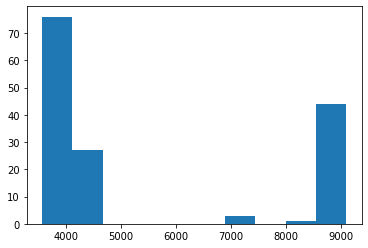

In [ ]:
plt.hist(valid_time0['rel_count'])

valid_time data shows max rel_time of ~3600 samples as expected. however, checking sampling counts,  irregularities had been found  [>8000 samples].

accounting this issue, rel_time will be re-calculate as the mean of each 0-3600 time sample

In [ ]:
df_all2 = df_all.groupby(['subject','activity','rel_time']).agg({'acceleration_x':'mean','acceleration_y':'mean','acceleration_z':'mean'}).reset_index()

#re-validating rel_time samples.
valid_time = pd.DataFrame(df_all2.groupby(['activity', 'subject'])['rel_time'].min())
valid_time['rel_count']= df_all2.groupby(['activity', 'subject'])['rel_time'].count()
#valid_time['time_count']= df.groupby(['activity', 'subject'])['time'].count()
valid_time['max rel_time']= df_all2.groupby(['activity', 'subject'])['rel_time'].max()

valid_time.head(5)

rel_time  rel_count  max rel_time
activity subject                                   
A        1600            0       3573          3597
         1601            0       3598          3598
         1602            0       3571          3595
         1603            0       3597          3597
         1604            0       3572          3596

(array([103.,  48.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([3000., 3600., 4200., 4800., 5400., 6000., 6600., 7200., 7800.,
        8400., 9000.]),
 <a list of 10 Patch objects>)

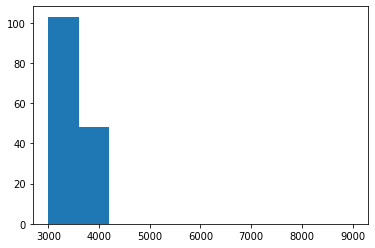

In [ ]:
plt.hist(valid_time['rel_count'], range=[3000,9000])

now samples is alligned with sample rate, at ~3600 readings per activity. 

samples were alligned but i want to remember suspicious subjects for later:

In [ ]:

valid_time0['rel_count'].mean()
valid_time0['rel_count'].std()

#Z-scoring function:
from scipy.stats import zscore
def zscore(array):
    return (sp.stats.zscore(array))
#z-scoring subject for counts:
valid_time0['Time_outliers'] = zscore(valid_time0['rel_count'])


#valid_time0['Time_outliers'] = valid_time0['outliers'].abs() >1

valid_time0.head(5)

rel_time  max rel_time  rel_count  time_count  Time_outliers
activity subject                                                              
A        1600            0          3597       3573        3573      -0.778888
         1601            0          3598       4511        4511      -0.382418
         1602            0          3595       3571        3571      -0.779733
         1603            0          3597       4509        4509      -0.383263
         1604            0          3596       3572        3572      -0.779310

In [ ]:
#just execute, dont ask why...
va=valid_time0.reset_index().set_index('subject')
va

,activity,rel_time,max rel_time,rel_count,time_count,Time_outliers
subject,,,,,,
1600,A,0,3597,3573,3573,-0.778888
1601,A,0,3598,4511,4511,-0.382418
1602,A,0,3595,3571,3571,-0.779733
1603,A,0,3597,4509,4509,-0.383263
1604,A,0,3596,3572,3572,-0.779310
...,...,...,...,...,...,...
1646,E,0,3598,8931,8931,1.485808
1647,E,0,3600,4512,4512,-0.381995
1648,E,0,3599,8932,8932,1.486231


,time,walk_count,run_count,stand_count
subject,,,,
1600,10717,3573,3572.0,3572
1601,13535,4511,4512.0,4512
1602,10716,3571,3572.0,3573
1603,13533,4509,4512.0,4512
1604,10719,3572,3573.0,3574


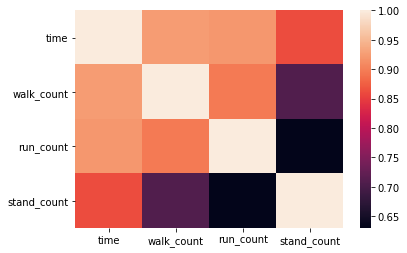

In [ ]:
#looking to see if sampling problem is rather global or consistent across activities of same subject:
valid_time0_corr = pd.DataFrame(df_all.groupby('subject')['time'].count())
# valid_time0.reset_index()
# valid_time0.set_index('subject', inplace = True)
valid_time0_corr['walk_count'] = va.loc[va['activity']=='A','time_count']
valid_time0_corr['run_count'] = va.loc[va['activity']=='B','time_count']
valid_time0_corr['stand_count'] = va.loc[va['activity']=='E','time_count']

sns.heatmap(valid_time0_corr.corr().abs())
valid_time0_corr.head()

#from heatmap we can see that hypersampling is correlated between activities among the same subject. 

In [ ]:
#updating df_all
df_all=df_all2
#in case you want to reverse:
#df_all=df_backup

## 2. Cleaning the gravity vector:
Accelerometers measures applied forces in 3 dimentions(vertical,horizontal and depth). however, one constant force that always works is the earth's gravity. 
gravity = 9.8 m\s^2. 
when our phone is stationary, and leveled (screen upside), we would see a +9.8 constant acceleration on Z axis - as expression of the gravity force. 
cleaning gravity is essential to analyse the accelerometer signal. However, scince while active, the device is out of level, cleaning gravity vector becomes a challenge, scince now gravity variants are expressed in all three dimentions. 

Since device inclanation is obscure to us, we can use 'standing' data as our reference point for device's inclanation in each axis. however, this correction is subject-wise. tailored for each subject from his own data.

from standing XYZ plot we can infere that for subject 1615, device was held horizontal to earth - as x axis shows constant of 9.8 m/s^2 acc
also device was a bit offset down-forward (y-axis is in constant -acc) and face-upward (z-axis is in constant +acc)

In [ ]:
#first thing first: devide the giagantic dataframe into activity-specific dataframes:
df_walk = df_all[df_all['activity'] == 'A'].reset_index(drop=True)
df_run = df_all[df_all['activity'] == 'B'].reset_index(drop=True)
df_stand = df_all[df_all['activity'] == 'E'].reset_index(drop=True)

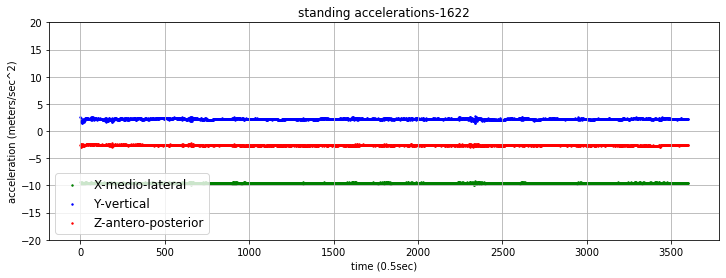

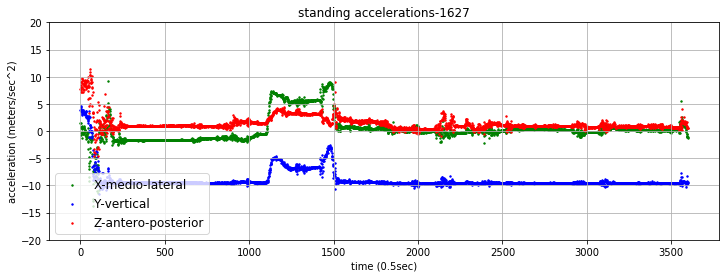

In [ ]:
#plotting for standing accelerations: (feel free to inspect different subjects between 1600 to 1650)
subjects = [1622,1627]

for subject in subjects:
    name= subject
    plt.figure(figsize=(12,4))
    w=plt.scatter(df_stand[df_stand['subject'] == subject].rel_time, df_stand[df_stand['subject'] == subject]['acceleration_x'],s=2, c='g', marker='o')
    r=plt.scatter(df_stand[df_stand['subject'] == subject].rel_time, df_stand[df_stand['subject'] == subject]['acceleration_y'],s=2, c='b', marker='o')
    s=plt.scatter(df_stand[df_stand['subject'] == subject].rel_time, df_stand[df_stand['subject'] == subject]['acceleration_z'],s=2, c='r', marker='o')
    plt.ylim(ymax = 20, ymin = -20)
    plt.title(f'standing accelerations-{name}')
    plt.xlabel('time (0.5sec)')
    plt.ylabel('acceleration (meters/sec^2)')
    plt.legend((w, r, s),
               ('X-medio-lateral', 'Y-vertical', 'Z-antero-posterior'),
               scatterpoints=1,
               loc='lower left',
               ncol=1,
               fontsize=12)
    plt.grid(True)
    plt.show()


Two things we should keep in mind from the above examples:
1. device's orientation is differed across subjects. for instance: in subject 1622 gravity vector is highly expressed in Y axis - meaning that device has been held horizontally. in sub1627, we can see that most of gravity vector is expressed on Y axis - while holding the device vertically. 
2. even while standing, some subjects were less stable than others - as expressed by robust noise in accelerometer reading - that will have a negative effect on gravitiy vector calculations. 

In [ ]:
#calculating gravity vector: 
#since relatively constant, we can use a single aggregated parameter (mean) for each axis:
df_grav = df_stand.groupby('subject').agg({'acceleration_x':['mean','std'], 'acceleration_y':['mean','std'], 'acceleration_z':['mean','std']}).reset_index()

df_grav.set_index('subject', drop = False, inplace = True)
df_grav.columns= ['subject', 'X','Xstd', 'Y','Ystd', 'Z', 'Zstd']

#gravity vector is extracted by 3D Pythagorean Theorem: 
df_grav['Gravity'] = np.sqrt((df_grav['X'])**2 +(df_grav['Y'])**2 +(df_grav['Z'])**2)
df_grav= df_grav[['subject','Gravity','X','Y','Z','Xstd','Ystd','Zstd']]

#looking for gravity outliers:
df_grav['Grav_outliers'] = zscore(df_grav['Gravity'])
#valid_time0['Time_outliers'] = valid_time0['outliers'].abs() >1

df_grav['Gravity'].mean()
df_grav['Gravity'].std()




mean gravity is: 9.690271544110722 ( 0.25905277424504836 )


mean gravity is: 9.690271544110722 ( 0.25905277424504836 )


(array([ 2.,  2.,  1.,  5.,  4., 14., 15.,  5.,  1.,  2.]),
 array([-2.77154471, -2.26951409, -1.76748347, -1.26545285, -0.76342222,
        -0.2613916 ,  0.24063902,  0.74266964,  1.24470027,  1.74673089,
         2.24876151]),
 <a list of 10 Patch objects>)

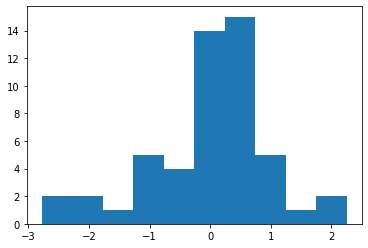

In [ ]:
print('mean gravity is:', df_grav['Gravity'].mean(),'(',df_grav['Gravity'].std(),')')
plt.hist(df_grav.Grav_outliers)

extracting gravity vector for each subject, we can see that all vectors are around the true 9.8 gravity force (Gravity mean=9.7, std=0.25). 
the next step is to adjust each axis by reducing its gravity component, as taken from subject's standig state. 

In [ ]:
#functions for adjusting accelerations:
def gravX(row):
    return (row.loc['acceleration_x']- df_grav.loc[row.loc['subject'], 'X'])
def gravY(row):
    return (row.loc['acceleration_y']- df_grav.loc[row.loc['subject'], 'Y'])
def gravZ(row):
    return (row.loc['acceleration_z']- df_grav.loc[row.loc['subject'], 'Z'])

#gravity-reduced adjusted accelerations for all subjects:
df_all['adjX']= df_all.apply(gravX, axis=1)
df_all['adjY']= df_all.apply(gravY, axis=1)
df_all['adjZ']= df_all.apply(gravZ, axis=1)



In [ ]:
df_all.head()

,subject,activity,rel_time,acceleration_x,acceleration_y,acceleration_z,adjX,adjY,adjZ
0,1600,A,0,-0.879730,9.768784,1.016998,1.266777,0.257875,0.198325
1,1600,A,1,2.001495,11.109070,2.619156,4.148003,1.598161,1.800483
2,1600,A,2,0.450623,12.651642,0.184555,2.597130,3.140733,-0.634118
3,1600,A,3,-2.164352,13.928436,-4.422485,-0.017845,4.417527,-5.241158
4,1600,A,4,-4.332779,13.361191,-0.718872,-2.186272,3.850282,-1.537545


In [ ]:
#Slicing df_all to specific activities:
df_walk = df_all.loc[df_all['activity']== 'A'].iloc[:,[0,1,2,6,7,8,]]
df_run  = df_all.loc[df_all['activity']== 'B'].iloc[:,[0,1,2,6,7,8,]]
df_stand1 = df_all.loc[df_all['activity']== 'E'].iloc[:,[0,1,2,6,7,8,]]
df_stand1

,subject,activity,rel_time,adjX,adjY,adjZ
7145,1600,E,0,-0.176643,-0.006667,-0.047204
7146,1600,E,1,-0.086159,-0.001616,-0.043557
7147,1600,E,2,-0.071693,0.009065,-0.082757
7148,1600,E,3,-0.017555,0.005403,-0.072747
7149,1600,E,4,0.042946,0.013063,-0.065850
...,...,...,...,...,...,...
541849,1650,E,3595,-0.436513,0.609032,-0.400015
541850,1650,E,3596,-0.506368,0.520416,-0.796390
541851,1650,E,3597,-0.339515,0.483293,-0.659874
541852,1650,E,3598,-0.285228,0.486087,0.472172


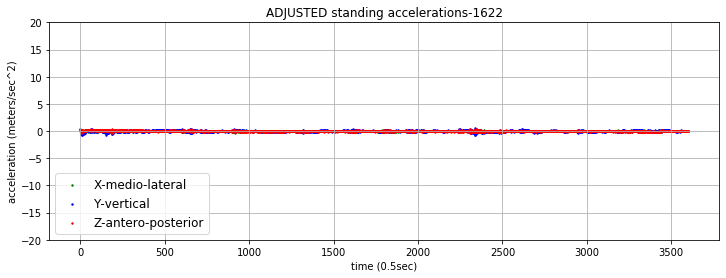

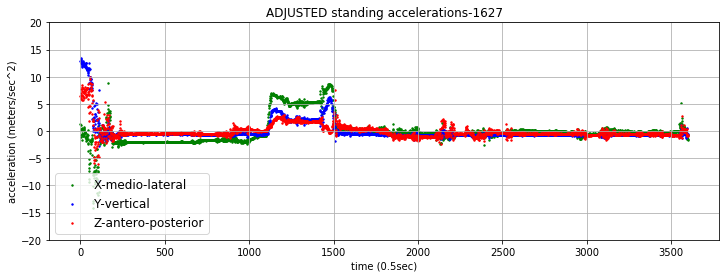

In [ ]:
#plotting for Adjusted standing accelerations: 
#as followed figures show - much better success with stable subjects (1622)...

subjects = [1622,1627]

for subject in subjects:
    name= subject
    plt.figure(figsize=(12,4))
    w=plt.scatter(df_stand1[df_stand1['subject'] == subject].rel_time, df_stand1[df_stand1['subject'] == subject]['adjX'],s=2, c='g', marker='o')
    r=plt.scatter(df_stand1[df_stand1['subject'] == subject].rel_time, df_stand1[df_stand1['subject'] == subject]['adjY'],s=2, c='b', marker='o')
    s=plt.scatter(df_stand1[df_stand1['subject'] == subject].rel_time, df_stand1[df_stand1['subject'] == subject]['adjZ'],s=2, c='r', marker='o')
    plt.ylim(ymax = 20, ymin = -20)
    plt.title(f'ADJUSTED standing accelerations-{name}')
    plt.xlabel('time (0.5sec)')
    plt.ylabel('acceleration (meters/sec^2)')
    plt.legend((w, r, s),
               ('X-medio-lateral', 'Y-vertical', 'Z-antero-posterior'),
               scatterpoints=1,
               loc='lower left',
               ncol=1,
               fontsize=12)
    plt.grid(True)
    plt.show()

##3. Extracting velocity from adjusted acceleration data:
Following adjusting for device orientation for each subject, we lay uppon robust assumption that orientation remains the same along all subject's activities. (this assumption is most likely false, but its the best I've got in my so-far limited domain-expertee in signals analysis).

My next objective was to extract each subject's movment velocity, as a function of (gravity-adjusted)acceleration vector. 

Acceleration defined as *'change in velocity over change in time'  *  getting into deep methematics, extracting velocity is generally posible, by calculating acceleration *integral* in a given time. 

(*note: it is more accurate to say that ACC integral is the change in velocity (i.e. V1-V0). uncorrecting this, would cause a 'dragging' effect of velocity. but than again, unfortunately beyond my reach at this time...*) 

In [ ]:
#getting velocity column from acceleration for each axis:
df_run['xvel']= (df_run['adjX'])*0.05 # *0.05 is for 20hz datapoints
df_run['yvel']= (df_run['adjY'])*0.05
df_run['zvel']= (df_run['adjZ'])*0.05

#summing axis-specific velocity data to means:
df_run_vel= pd.DataFrame(df_run.groupby('subject')['xvel'].sum()/180*3.6)
df_run_vel['yvel']= df_run.groupby('subject')['yvel'].sum()/180*3.6
df_run_vel['zvel']= df_run.groupby('subject')['zvel'].sum()/180*3.6

#total velocity magnitude vector is extracted by 3D Pythagorean Theorem: 
df_run_vel['Velocity'] = np.sqrt(df_run_vel['xvel']**2 + df_run_vel['yvel']**2 + df_run_vel['zvel']**2)

df_run_vel['Xacc']= df_run.groupby('subject')['adjX'].mean()
df_run_vel['Yacc']= df_run.groupby('subject')['adjY'].mean()
df_run_vel['Zacc']= df_run.groupby('subject')['adjZ'].mean()

df_run_vel.head()

,xvel,yvel,zvel,Velocity,Xacc,Yacc,Zacc
subject,,,,,,,
1600,3.841636,-3.936309,-7.510087,9.308818,1.075486,-1.101990,-2.102488
1601,3.738881,-4.404026,0.967490,5.857535,1.038290,-1.223001,0.268672
1602,6.833204,-66.488093,4.897758,67.017515,1.912991,-18.613688,1.371153
1603,5.116623,-8.646272,0.273985,10.050518,1.421284,-2.401742,0.076107
1604,-6.941797,-2.469459,-5.893336,9.434945,-1.942848,-0.691144,-1.649408


velocity calculation has got us some odd data.. 
some subjects running velocities are ridiculusly high (for instance: subject 1629 - 64 km\hour ). 
that requires a little further investigation.. 


(array([ 5., 12., 10.,  4.,  2.,  1.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  2.,  1.,  0.,  1.,  2.]),
 array([ 3.08471993,  6.36141747,  9.63811502, 12.91481256, 16.19151011,
        19.46820765, 22.7449052 , 26.02160274, 29.29830029, 32.57499783,
        35.85169538, 39.12839292, 42.40509047, 45.68178801, 48.95848556,
        52.2351831 , 55.51188065, 58.78857819, 62.06527574, 65.34197328,
        68.61867083]),
 <a list of 20 Patch objects>)

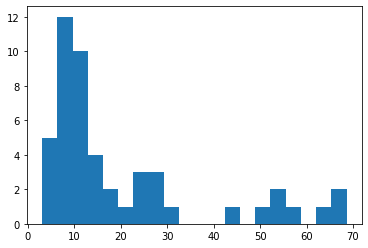

In [ ]:
plt.hist(df_run_vel['Velocity'], bins=20)

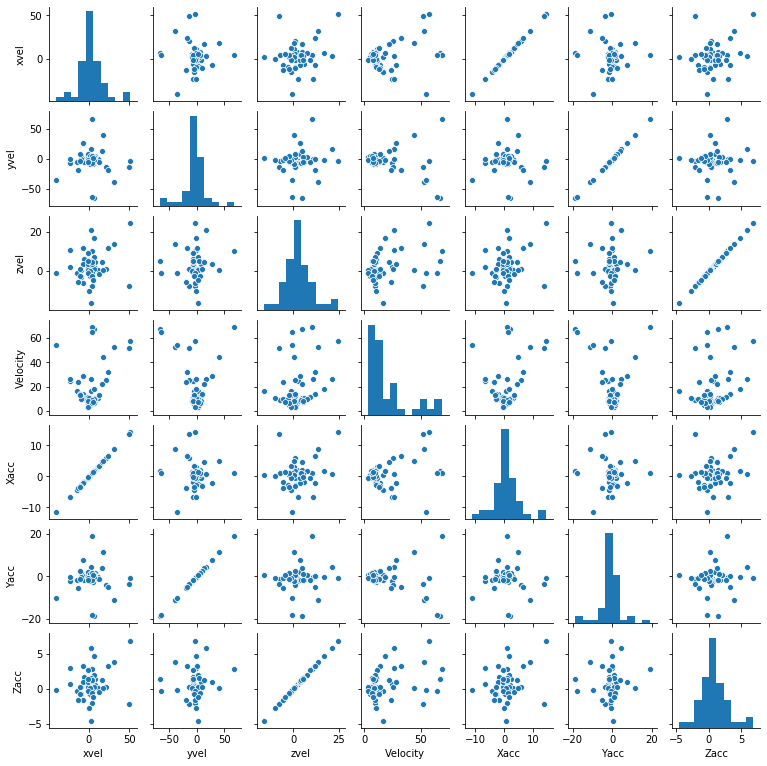

In [ ]:
sns.pairplot(df_run_vel, height=1.5)

a glance on ACC histograms reveals few abnormalities, in Xacc (positive outliers) and Yacc (negative outliers)

*infact, this data is so distorted so Zacc histogram shows us what she thinks about it....*

In [ ]:
print(df_run_vel['Xacc'].sort_values(ascending=False).head())
print(df_run_vel['Yacc'].sort_values(ascending=True).head())
print(df_run_vel['Zacc'].sort_values(ascending=False).head())

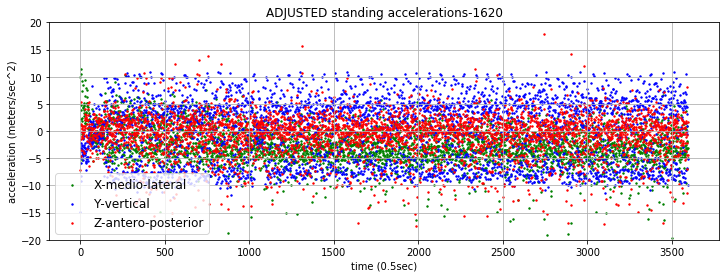

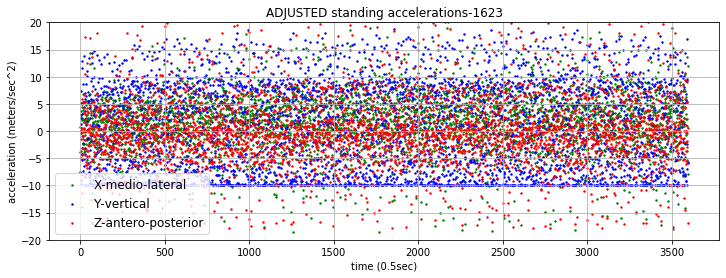

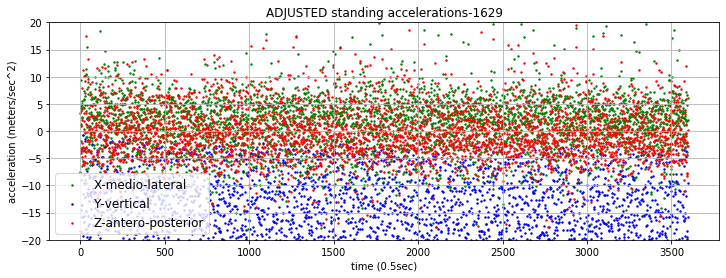

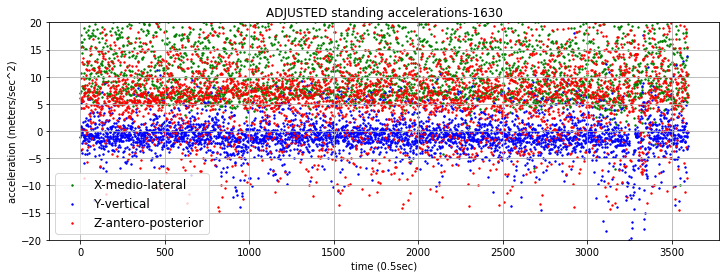

In [ ]:
#plotting for running accelerations: 
#as followed figures show - unreal velocities are outcome of shift in axis.
# compare subject 1620 (Yacc =-0.21, velocity = 10.2) and subject 1629 (Yacc = -18.04, velocity = 64.6),
# as noted by blue dots in refered scatterplots. 

subjects = [1620,1623,1629,1630]

for subject in subjects:
    name= subject
    plt.figure(figsize=(12,4))
    w=plt.scatter(df_run[df_run['subject'] == subject].rel_time, df_run[df_run['subject'] == subject]['adjX'],s=2, c='g', marker='o')
    r=plt.scatter(df_run[df_run['subject'] == subject].rel_time, df_run[df_run['subject'] == subject]['adjY'],s=2, c='b', marker='o')
    s=plt.scatter(df_run[df_run['subject'] == subject].rel_time, df_run[df_run['subject'] == subject]['adjZ'],s=2, c='r', marker='o')
    plt.ylim(ymax = 20, ymin = -20)
    plt.title(f'ADJUSTED standing accelerations-{name}')
    plt.xlabel('time (0.5sec)')
    plt.ylabel('acceleration (meters/sec^2)')
    plt.legend((w, r, s),
               ('X-medio-lateral', 'Y-vertical', 'Z-antero-posterior'),
               scatterpoints=1,
               loc='lower left',
               ncol=1,
               fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
df_run_vel['Vel_outliers'] = zscore(df_run_vel['Velocity'])
#valid_time0['Time_outliers'] = valid_time0['outliers'].abs() >1

print ('mean velocity is:', df_run_vel['Velocity'].mean(), df_run_vel['Velocity'].std())

df_run_vel.head()

mean velocity is: 20.22300695860025 18.27111481806367


,xvel,yvel,zvel,Velocity,Xacc,Yacc,Zacc,Vel_outliers
subject,,,,,,,,
1600,3.841636,-3.936309,-7.510087,9.308818,1.075486,-1.101990,-2.102488,-0.603537
1601,3.738881,-4.404026,0.967490,5.857535,1.038290,-1.223001,0.268672,-0.794387
1602,6.833204,-66.488093,4.897758,67.017515,1.912991,-18.613688,1.371153,2.587660
1603,5.116623,-8.646272,0.273985,10.050518,1.421284,-2.401742,0.076107,-0.562522
1604,-6.941797,-2.469459,-5.893336,9.434945,-1.942848,-0.691144,-1.649408,-0.596562


(array([ 5., 12., 10.,  4.,  2.,  1.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  2.,  1.,  0.,  1.,  2.]),
 array([ 3.08471993,  6.36141747,  9.63811502, 12.91481256, 16.19151011,
        19.46820765, 22.7449052 , 26.02160274, 29.29830029, 32.57499783,
        35.85169538, 39.12839292, 42.40509047, 45.68178801, 48.95848556,
        52.2351831 , 55.51188065, 58.78857819, 62.06527574, 65.34197328,
        68.61867083]),
 <a list of 20 Patch objects>)

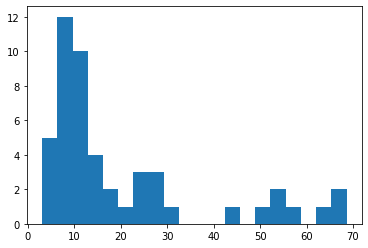

In [ ]:
plt.hist(df_run_vel['Velocity'], bins=20)

In [ ]:
#before start choping heads, i tryed one more thing. 
#since all of our subjects have ended their running session by halting (hopfully..) 
#accelerations means should be ZERO. 
#Hence - maybe we can shift axes ACC distributions to work around Zero line..



#functions for zeroing accelerations:
def ZeroX(row):
    return (row.loc['adjX']- df_run_vel.loc[row.loc['subject'], 'Xacc'])
def ZeroY(row):
    return (row.loc['adjY']- df_run_vel.loc[row.loc['subject'], 'Yacc'])
def ZeroZ(row):
    return (row.loc['adjZ']- df_run_vel.loc[row.loc['subject'], 'Zacc'])




In [ ]:
df_run_zero = df_run

In [ ]:
#mean-reduced adjusted accelerations for all subjects in run:
df_run_zero['ZeroX']= df_run_zero.apply(ZeroX, axis=1)
df_run_zero['ZeroY']= df_run_zero.apply(ZeroY, axis=1)
df_run_zero['ZeroZ']= df_run_zero.apply(ZeroZ, axis=1)

df_run_zero.head()

,subject,activity,rel_time,adjX,adjY,adjZ,xvel,yvel,zvel,ZeroX,ZeroY,ZeroZ
3573,1600,B,0,3.522057,5.864137,2.152946,0.122329,0.348306,0.212772,2.446571,6.966127,4.255434
3574,1600,B,1,-1.787926,8.027879,1.291343,-0.143171,0.456493,0.169692,-2.863412,9.129869,3.393831
3575,1600,B,2,2.058769,3.280656,-2.272775,0.049164,0.219132,-0.008514,0.983283,4.382646,-0.170287
3576,1600,B,3,4.185249,-6.433761,-1.872399,0.155488,-0.266589,0.011504,3.109763,-5.331771,0.230089
3577,1600,B,4,-0.411964,-12.249587,-2.917184,-0.074373,-0.557380,-0.040735,-1.487450,-11.147597,-0.814696


In [ ]:
#getting velocity column from acceleration for each axis:
df_run_zero['xvel']= (df_run_zero['ZeroX'])*0.05 # *0.05 is for 20hz datapoints
df_run_zero['yvel']= (df_run_zero['ZeroY'])*0.05
df_run_zero['zvel']= (df_run_zero['ZeroZ'])*0.05

#summing axis-specific velocity data to means:
df_run_vel_zero= pd.DataFrame(df_run_zero.groupby('subject')['xvel'].sum()/180*3.6)
df_run_vel_zero['yvel']= df_run_zero.groupby('subject')['yvel'].sum()/180*3.6
df_run_vel_zero['zvel']= df_run_zero.groupby('subject')['zvel'].sum()/180*3.6

#total velocity magnitude vector is extracted by 3D Pythagorean Theorem: 
df_run_vel_zero['Velocity'] = np.sqrt(df_run_vel_zero['xvel']**2 + df_run_vel_zero['yvel']**2 + df_run_vel_zero['zvel']**2)

df_run_vel_zero['ZeroXacc']= df_run_zero.groupby('subject')['ZeroX'].mean()
df_run_vel_zero['ZeroYacc']= df_run_zero.groupby('subject')['ZeroY'].mean()
df_run_vel_zero['ZeroZacc']= df_run_zero.groupby('subject')['ZeroZ'].mean()


In [ ]:
df_run_vel_zero.head()

,xvel,yvel,zvel,Velocity,ZeroXacc,ZeroYacc,ZeroZacc
subject,,,,,,,
1600,4.430900e-15,1.030481e-14,7.642775e-15,1.357328e-14,1.325803e-15,3.091405e-15,1.934001e-15
1601,1.696594e-15,-7.128520e-14,1.758593e-15,7.132707e-14,3.368283e-16,-1.979595e-14,4.449525e-16
1602,-2.827183e-14,-2.056785e-13,-1.900591e-14,2.084806e-13,-8.044828e-15,-5.730243e-14,-5.079550e-15
1603,5.596079e-15,-1.013523e-13,-1.194045e-15,1.015137e-13,2.169129e-15,-2.690194e-14,-5.609093e-16
1604,-1.063177e-14,7.038814e-16,-1.306150e-14,1.685624e-14,-2.976504e-15,2.107963e-16,-3.751330e-15


(array([36.,  3.,  5.,  2.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([2.77679644e-15, 4.82144154e-14, 9.36520344e-14, 1.39089653e-13,
        1.84527272e-13, 2.29964891e-13, 2.75402510e-13, 3.20840129e-13,
        3.66277748e-13, 4.11715367e-13, 4.57152986e-13]),
 <a list of 10 Patch objects>)

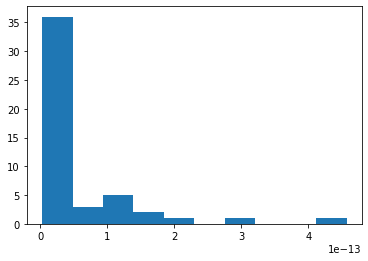

In [ ]:
plt.hist(df_run_vel_zero['Velocity'])

Well.. that didn't go too well...

Maybe we'll have more luck with walking data..

In [ ]:
#getting velocity column from acceleration for each axis:
df_walk['xvel']= (df_walk['adjX'])*0.05 # *0.05 is for 20hz datapoints
df_walk['yvel']= (df_walk['adjY'])*0.05
df_walk['zvel']= (df_walk['adjZ'])*0.05

#summing axis-specific velocity data to means:
df_walk_vel= pd.DataFrame(df_walk.groupby('subject')['xvel'].sum()/180*3.6)
df_walk_vel['yvel']= df_walk.groupby('subject')['yvel'].sum()/180*3.6
df_walk_vel['zvel']= df_walk.groupby('subject')['zvel'].sum()/180*3.6

#total velocity magnitude vector is extracted by 3D Pythagorean Theorem: 
df_walk_vel['Velocity'] = np.sqrt(df_walk_vel['xvel']**2 + df_walk_vel['yvel']**2 + df_walk_vel['zvel']**2)

df_walk_vel['Xacc']= df_walk.groupby('subject')['adjX'].mean()
df_walk_vel['Yacc']= df_walk.groupby('subject')['adjY'].mean()
df_walk_vel['Zacc']= df_walk.groupby('subject')['adjZ'].mean()

df_walk_vel['Vel_walk_outliers'] = zscore(df_walk_vel['Velocity'])
#valid_time0['Time_outliers'] = valid_time0['outliers'].abs() >1

print ('mean velocity is:', df_walk_vel['Velocity'].mean(), df_walk_vel['Velocity'].std())



df_walk_vel.head()

mean velocity is: 20.255012372150667 22.355124476668376


,xvel,yvel,zvel,Velocity,Xacc,Yacc,Zacc,Vel_walk_outliers
subject,,,,,,,,
1600,1.028310,0.144353,-1.438554,1.774175,0.287800,0.040401,-0.402618,-0.834920
1601,7.554183,-2.177088,1.705485,8.044506,2.099551,-0.605083,0.474009,-0.551641
1602,7.102271,-69.364921,5.778509,69.966604,1.988874,-19.424509,1.618177,2.245850
1603,1.279762,0.248367,0.562843,1.419953,0.355786,0.069048,0.156476,-0.850922
1604,-3.829606,1.350163,-5.686184,6.987239,-1.072118,0.377985,-1.591877,-0.599406


(array([ 5., 12., 10.,  4.,  2.,  1.,  3.,  3.,  1.,  0.,  0.,  0.,  1.,
         0.,  1.,  2.,  1.,  0.,  1.,  2.]),
 array([ 3.08471993,  6.36141747,  9.63811502, 12.91481256, 16.19151011,
        19.46820765, 22.7449052 , 26.02160274, 29.29830029, 32.57499783,
        35.85169538, 39.12839292, 42.40509047, 45.68178801, 48.95848556,
        52.2351831 , 55.51188065, 58.78857819, 62.06527574, 65.34197328,
        68.61867083]),
 <a list of 20 Patch objects>)

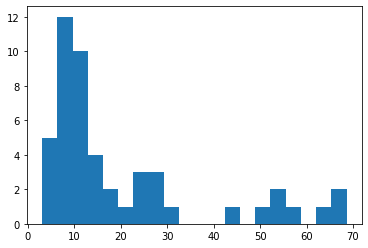

In [ ]:
plt.hist(df_run_vel['Velocity'], bins=20)

In [ ]:
df_walk_vel